In [3]:
import numpy as np
from classfunctions import NbodyClass
import matplotlib.pyplot as mpl
from mpl_toolkits.mplot3d import Axes3D

## Part 4

This method starts the universe where the particle density is generated from a k^-3 distribution.



### Contents:
- functions for mass distribution generation
- k^-3 mass fluctation distribution images
- Mass density grid compared to distribution
- Nbody simulation results
- Code used for running the simulations

First, I run a large k^-3 distribution (based off https://garrettgoon.com/gaussian-fields/) and plot slices of it to demonstrate that it is as expected. Then I generate a particle distribution and plot the density grid and compare it to the k^-3 distribution. Then a k^-3 distribution is used to start the nbody simulation.


In [4]:
#this code generates the k^-3 power distribution in the spatial frequency domain
def power_dist(num, DEBUG=False):
        dx = np.arange(num)            
        dx[num//2:] = dx[num//2:]-num
        if DEBUG:
            print('dx before multiplication by 2pi/num is ', dx)
        dx = 2*np.pi/num*dx # how it's done in garrett goon

        #distances away from particle in x, y, z
        #particle lives at 0, 0, 0
        xmesh, ymesh, zmesh = np.meshgrid(dx,dx,dx) 
        dr = np.sqrt(xmesh**2 + ymesh**2 + zmesh**2)

        #point at 0,0,0 is 0 and will blow up
        dr[0, 0, 0] = 1 #temporarily make it one
        k_map = dr**(-3) #create the square root of the power distribution
        k_map[0, 0, 0] = 0 #was temporarily made 1 to not explode
        
        if DEBUG:
#             print('dr x = 0 is \n ', dr[0, :, :])
            mpl.imshow(dr[0, :, :], cmap='hot')
            mpl.title('dr x=0 2D slice')
            mpl.show()    
        
            mpl.imshow(k_map[0, :, :], cmap='hot')
            mpl.title('kmap x=0 2D slice')
            mpl.show()

        return k_map

In [5]:
#this code generates a grid of k^-3 mass fluctuations
def generate_mass_fluctuations(num, DEBUG=False):
    
    #generate the intial power spectrum data
    norm_data = np.random.normal(size=(num, num, num))
    fft_dat = np.fft.fftn(norm_data)
    
    if DEBUG:
        mpl.figure()
        mpl.imshow(abs(fft_dat[0, :, :]), cmap='hot')
        mpl.title('abs of FT of random noise 2D slice x=0')
        mpl.colorbar()
        mpl.show()
        
        
    #get the power spectrum and multiply by the fourier space data
    pwr_spec = power_dist(num, DEBUG)
    
    fft_dat = fft_dat*pwr_spec
    dat = np.fft.ifftn(fft_dat)
    
    if DEBUG:
        mpl.figure()
        mpl.imshow(np.real(dat[5, :, :]), cmap='hot')
        mpl.title('real of FT of random noise 2D slice x=5')
        mpl.colorbar()
        mpl.show()
        
    return np.real(dat)

#this function provides start positions of particles drawn from the mass distribution
def generate_start_poisitions(num, num_part, DEBUG=False):
    #first get the mass fluctuation grid
    flucs = generate_mass_fluctuations(num, DEBUG=False)
    flucs -= np.min(flucs)
    flucs/= np.max(flucs)
    
    if DEBUG:
        mpl.imshow(flucs[:, 5, :], cmap='hot')
        mpl.title('normalized fluctuations 2D slice y=5')
        mpl.colorbar()
        mpl.show()

    #sample the probability grid with particles. preference to keep those in the higher probability areas.
    #do this by: randomly creating particles, and a second random 'keep' vector. if the particle's 'keep'
    #index is within the probability of the cell where it winds up, keep it! if not, throw it out.
    
    #sample the grid with particles.
    x = num*np.random.rand(3, num_part)
    keep = np.random.rand(num_part)
    idx_keep = np.zeros(num_part, dtype=bool)
    
    x_idx = x.copy().astype(int)

    for ii in range(num_part):
        idx_keep[ii] = keep[ii] < flucs[x_idx[0, ii], x_idx[1, ii], x_idx[2, ii]]

    x_out = x[:, idx_keep]
    
    if DEBUG:
        print(num_part, ' particles started')
        print(x_out.shape[1], ' particles kept')
        print('max and min of flucs are ', np.max(flucs), np.min(flucs))
    
    return x_out

### k^-3 mass fluctation distribution <a name="dist"></a>
A large grid size picture of the k^-3 distribution is generated and shown in the cell below.

The generation was heavily based off of the work done in Mathematica here: https://garrettgoon.com/gaussian-fields/

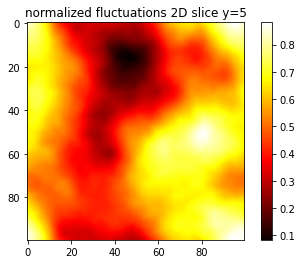

500000  particles started
241891  particles kept
max and min of flucs are  1.0 0.0
(3, 241891)


In [35]:
#Large image of distribution map

num = 100
num_part = 5*10**5
x = generate_start_poisitions(num, num_part, DEBUG=True)
print(x.shape)

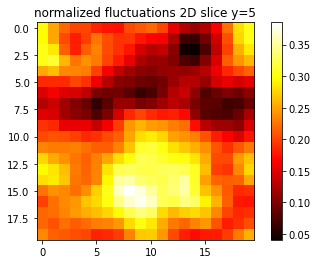

10000000  particles started
4138674  particles kept
max and min of flucs are  1.0 0.0


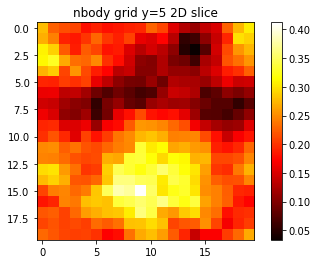

In [31]:
#produce heat maps of the nbody density grid with the particles
#show that it looks like the heatmap of the normalized fluctuations, with a little extra randomness
#but need enough particles to see, plot with smaller spread.
num_part = 10**7
steps = 2
spread = 20

pos = generate_start_poisitions(spread, num_part, DEBUG=True)
vel = np.zeros( (3, num_part) )

nbody = NbodyClass(pos, vel, dt=0.1, sgrid=spread, periodic=True, gradient=True)
nbody.update_grid()

mpl.figure()
mpl.imshow(nbody.grid[:, 5, :]/np.max(nbody.grid), cmap='hot')
mpl.title('nbody grid y=5 2D slice')
mpl.colorbar()
mpl.show()

The above two pictures show the distribution of particles being successfully drawn from the k^-3 distribution. The top image above shows a 2D slice of the k^-3 distribution, and the bottom image shows the density map of the particles in the same slice. The two are very similar, with some slight extra randomness shown in the density map of the particles.

### Nbody simulation results <a name="step"></a>
The next component was to run the nbody simulator in a periodic mode with the initial particle density drawn from the k^-3 distribution.

How does our universe look now? Due to the non-uniform density distribution, rather than the small clumps that we found previously in Part 3, the model in Part 4 collapses more quickly to a single clump. However, as it is collapsing, we can see some interesting tendril-like structures appear briefly (look at the bottom of the grid in the x-y plane). Possibly with a larger grid and more cells, the tendril structures would be more evident, but larger simulations take prohibitively long to run. Possible future work for this project could include improving simulation speed using various optimizing techniques, including using a smaller data type and Numba.

<img src="part4Outputs/grid50step99soften1/grid50step99soften1output.gif" width="800" height="800"/>


<!-- <img src="part4Outputs/grid20step99soften1/grid20step99soften1output.gif" width="800" height="800"/> -->

##### Energy
We find the same energy characteristics in Part 3, where during the collapse the potential energy shoots up, dominating the kinetic energy, only to decrease as we reach steady state, and find a constant value where it stays. We can see this in the plots below, where we show the total energy for all the particles in the system. Both the kinetic, potential, and total energy are displayed in these plots.

Therefore we can say that the model is not accurately dealing with the energy during the intensity of the inital collapse, but conserves it decently before and after.

<img src="part4Outputs/grid50step99soften1/potentialenergy.png" width="300" height="800"/>
<img src="part4Outputs/grid50step99soften1/kineticenergy.png" width="300" height="800"/>


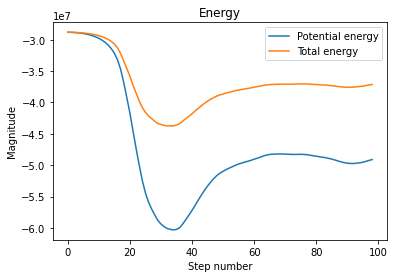

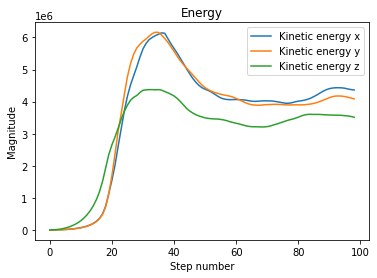

In [26]:
#read in and make nice graphs of energy

# f1 = "part3PeriodicOutputs/grid50step99soften1/grid50step99soften1poten.npy"
# f2 = "part3PeriodicOutputs/grid50step99soften1/grid50step99soften1kinen.npy"
f1 = "part4Outputs/grid50step99soften1/grid50step99soften1poten.npy"
f2 = "part4Outputs/grid50step99soften1/grid50step99soften1kinen.npy"
pe = np.load(f1)
ke = np.load(f2)

numsteps = 99

mpl.figure()
mpl.plot(range(numsteps), pe[:numsteps])
mpl.plot(range(numsteps), pe[:numsteps] + np.sum(ke[:, :numsteps], axis=0))
mpl.legend(['Potential energy', 'Total energy'])
mpl.title('Energy')
mpl.xlabel('Step number')
mpl.ylabel('Magnitude')
mpl.show()

mpl.figure()
mpl.plot(range(numsteps), ke[0, :numsteps])
mpl.plot(range(numsteps), ke[1, :numsteps])
mpl.plot(range(numsteps), ke[2, :numsteps])
mpl.legend(['Kinetic energy x', 'Kinetic energy y', 'Kinetic energy z'])
mpl.title('Energy')
mpl.xlabel('Step number')
mpl.ylabel('Magnitude')
mpl.show()

## Code for running.
Below is the code that I used to:
- run the nbody simulation
- save the run information
- plot and save the energy information

Below is shown a couple runs that I duplicated for convenience when running overnight. For actual gifs and results, see the Nobdy simulation results section from earlier.

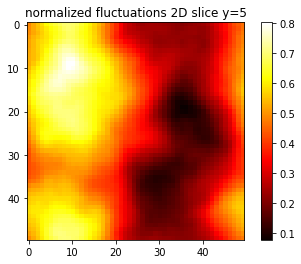

200000  particles started
86151  particles kept
max and min of flucs are  1.0 0.0


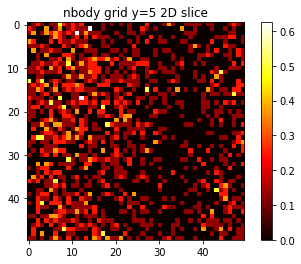

99

In [6]:
#run nbody steps see what the universe will look like. use periodic boundary conditions
num_part = 2*10**5
spread=50
periodic = True
vzero = True
soft=1
n = 99
gradient = True


name_prefix = "grid" + str(spread) + "step" + str(n) + "soften" + str(soft)
if periodic:
    outdir = "part4Outputs/" + name_prefix + "/" + name_prefix
else:
    outdir = "part4Outputs/" + name_prefix + "/" + name_prefix


pos = generate_start_poisitions(spread, num_part, DEBUG=True)
if vzero:
    v = np.zeros( (3, pos.shape[1]) )
else:
    v = np.random.rand(3, pos.shape[1])
    
#instantiate the class
nbody = NbodyClass(pos, v, outdir=outdir, sgrid=spread, periodic=periodic, gradient=gradient, soft=soft)
nbody.calculate_potential(DEBUG=False)

#display initial density grid
mpl.figure()
mpl.imshow(nbody.grid[:, 5, :]/np.max(nbody.grid), cmap='hot')
mpl.title('nbody grid y=5 2D slice')
mpl.colorbar()
mpl.show()

nbody.take_n_steps(n, plots=True, plot_every=1)

In [7]:
print('Run specs: ')
print('Periodic: ', periodic)
print('Grid cells: ', spread)
print('Number of particles: ', num_part)
print('Number of steps: ', n)
print('Velocities start at zero :', vzero)
print('Softening: ', soft)

readme = outdir+ "readme.txt"
print('printing to readme file ...', readme)
f = open(readme, "w")
f.write('Run specs:')
f.write('\nPeriodic: ' + str(periodic))
f.write('\nGrid cells: ' + str(spread))
f.write('\nNumber of particles: ' + str(num_part))
f.write('\nNumber selected: ' + str(pos.shape[1]))
f.write('\nNumber of steps: ' + str(n))
f.write('\nVelocities start at zero :' +  str(vzero))
f.write('\nSoftening: ' + str(soft))
f.write('\nGradient: ' + str(gradient))
f.close()

Run specs: 
Periodic:  True
Grid cells:  50
Number of particles:  200000
Number of steps:  99
Velocities start at zero : True
Softening:  1
printing to readme file ... part4Outputs/grid50step99soften1/grid50step99soften1readme.txt


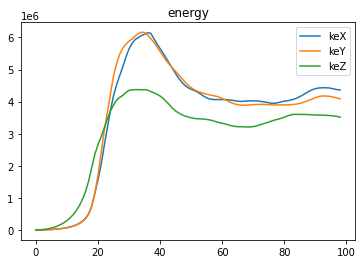

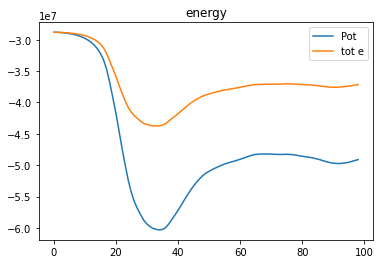

In [8]:
#plot the energy, see how well it's conserved
# nbody.plot_energy()
lims = 25

mpl.figure()
# mpl.plot(range(0, n), nbody.pe[:n])
mpl.plot(range(0, n), nbody.ke[0, :n])
mpl.plot(range(0, n), nbody.ke[1, :n])
mpl.plot(range(0, n), nbody.ke[2, :n])
# mpl.plot(range(0, n), nbody.pe[:n] + np.sum(nbody.ke, axis=0)[:n])
mpl.legend(['keX', 'keY', 'keZ'])
mpl.title('energy')
# mpl.xlim([0, lims])
mpl.show()

mpl.figure()
mpl.plot(range(0, n), nbody.pe[:n])
# mpl.plot(range(0, n), nbody.ke[0, :n])
# mpl.plot(range(0, n), nbody.ke[1, :n])
# mpl.plot(range(0, n), nbody.ke[2, :n])
mpl.plot(range(0, n), nbody.pe[:n] + np.sum(nbody.ke, axis=0)[:n])
mpl.legend(['Pot', 'tot e'])
# mpl.legend(['Pot', 'keX', 'keY', 'keZ', 'tot e'])
# mpl.xlim([0, lims])
mpl.title('energy')
mpl.show()

np.save(outdir + 'kinen', nbody.ke)
np.save(outdir + 'poten', nbody.pe)

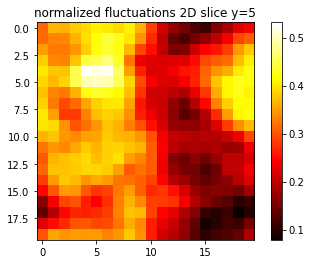

200000  particles started
95405  particles kept
max and min of flucs are  1.0 0.0


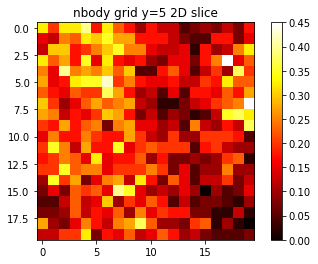

Run specs: 
Periodic:  True
Grid cells:  20
Number of particles:  200000
Number of steps:  99
Velocities start at zero : True
Softening:  1
printing to readme file ... part4Outputs/grid20step99soften1/grid20step99soften1readme.txt


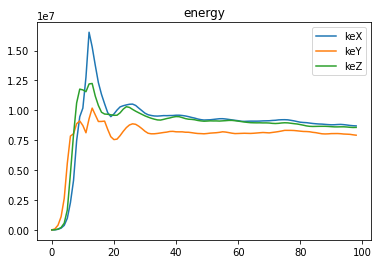

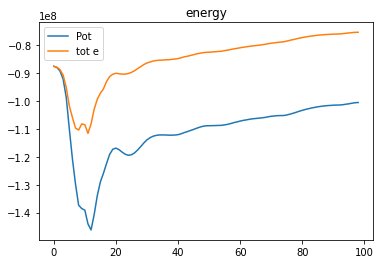

In [10]:
#run nbody steps see what the universe will look like. use periodic boundary conditions
num_part = 2*10**5
spread=20
periodic = True
vzero = True
soft=1
n = 99
gradient = True


name_prefix = "grid" + str(spread) + "step" + str(n) + "soften" + str(soft)
if periodic:
    outdir = "part4Outputs/" + name_prefix + "/" + name_prefix
else:
    outdir = "part4Outputs/" + name_prefix + "/" + name_prefix


pos = generate_start_poisitions(spread, num_part, DEBUG=True)
if vzero:
    v = np.zeros( (3, pos.shape[1]) )
else:
    v = np.random.rand(3, pos.shape[1])
    
#instantiate the class
nbody = NbodyClass(pos, v, outdir=outdir, sgrid=spread, periodic=periodic, gradient=gradient, soft=soft)
nbody.calculate_potential(DEBUG=False)

#display initial density grid
mpl.figure()
mpl.imshow(nbody.grid[:, 5, :]/np.max(nbody.grid), cmap='hot')
mpl.title('nbody grid y=5 2D slice')
mpl.colorbar()
mpl.show()

nbody.take_n_steps(n, plots=True, plot_every=1)

print('Run specs: ')
print('Periodic: ', periodic)
print('Grid cells: ', spread)
print('Number of particles: ', num_part)
print('Number of steps: ', n)
print('Velocities start at zero :', vzero)
print('Softening: ', soft)

readme = outdir+ "readme.txt"
print('printing to readme file ...', readme)
f = open(readme, "w")
f.write('Run specs:')
f.write('\nPeriodic: ' + str(periodic))
f.write('\nGrid cells: ' + str(spread))
f.write('\nNumber of particles: ' + str(num_part))
f.write('\nNumber selected: ' + str(pos.shape[1]))
f.write('\nNumber of steps: ' + str(n))
f.write('\nVelocities start at zero :' +  str(vzero))
f.write('\nSoftening: ' + str(soft))
f.write('\nGradient: ' + str(gradient))
f.close()

#plot the energy, see how well it's conserved
# nbody.plot_energy()
lims = 25

mpl.figure()
# mpl.plot(range(0, n), nbody.pe[:n])
mpl.plot(range(0, n), nbody.ke[0, :n])
mpl.plot(range(0, n), nbody.ke[1, :n])
mpl.plot(range(0, n), nbody.ke[2, :n])
# mpl.plot(range(0, n), nbody.pe[:n] + np.sum(nbody.ke, axis=0)[:n])
mpl.legend(['keX', 'keY', 'keZ'])
mpl.title('energy')
# mpl.xlim([0, lims])
mpl.show()

mpl.figure()
mpl.plot(range(0, n), nbody.pe[:n])
# mpl.plot(range(0, n), nbody.ke[0, :n])
# mpl.plot(range(0, n), nbody.ke[1, :n])
# mpl.plot(range(0, n), nbody.ke[2, :n])
mpl.plot(range(0, n), nbody.pe[:n] + np.sum(nbody.ke, axis=0)[:n])
mpl.legend(['Pot', 'tot e'])
# mpl.legend(['Pot', 'keX', 'keY', 'keZ', 'tot e'])
# mpl.xlim([0, lims])
mpl.title('energy')
mpl.show()

np.save(outdir + 'kinen', nbody.ke)
np.save(outdir + 'poten', nbody.pe)

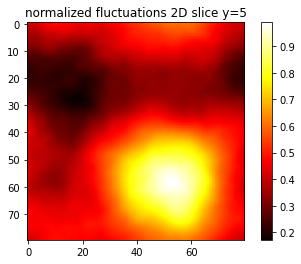

500000  particles started
192886  particles kept
max and min of flucs are  1.0 0.0


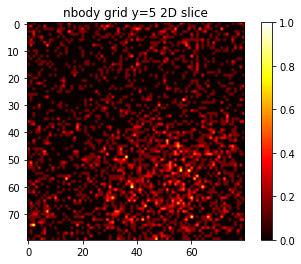

In [ ]:
#run nbody steps see what the universe will look like. use periodic boundary conditions
num_part = 5*10**5
spread=80
periodic = True
vzero = True
soft=1
n = 10
gradient = True


name_prefix = "grid" + str(spread) + "step" + str(n) + "soften" + str(soft)
if periodic:
    outdir = "part4Outputs/" + name_prefix + "/" + name_prefix
else:
    outdir = "part4Outputs/" + name_prefix + "/" + name_prefix


pos = generate_start_poisitions(spread, num_part, DEBUG=True)
if vzero:
    v = np.zeros( (3, pos.shape[1]) )
else:
    v = np.random.rand(3, pos.shape[1])
    
#instantiate the class
nbody = NbodyClass(pos, v, outdir=outdir, sgrid=spread, periodic=periodic, gradient=gradient, soft=soft)
nbody.calculate_potential(DEBUG=False)

#display initial density grid
mpl.figure()
mpl.imshow(nbody.grid[:, 5, :]/np.max(nbody.grid), cmap='hot')
mpl.title('nbody grid y=5 2D slice')
mpl.colorbar()
mpl.show()

nbody.take_n_steps(n, plots=True, plot_every=1)

print('Run specs: ')
print('Periodic: ', periodic)
print('Grid cells: ', spread)
print('Number of particles: ', num_part)
print('Number of steps: ', n)
print('Velocities start at zero :', vzero)
print('Softening: ', soft)

readme = outdir+ "readme.txt"
print('printing to readme file ...', readme)
f = open(readme, "w")
f.write('Run specs:')
f.write('\nPeriodic: ' + str(periodic))
f.write('\nGrid cells: ' + str(spread))
f.write('\nNumber of particles: ' + str(num_part))
f.write('\nNumber selected: ' + str(pos.shape[1]))
f.write('\nNumber of steps: ' + str(n))
f.write('\nVelocities start at zero :' +  str(vzero))
f.write('\nSoftening: ' + str(soft))
f.write('\nGradient: ' + str(gradient))
f.close()

#plot the energy, see how well it's conserved
# nbody.plot_energy()
lims = 25

mpl.figure()
# mpl.plot(range(0, n), nbody.pe[:n])
mpl.plot(range(0, n), nbody.ke[0, :n])
mpl.plot(range(0, n), nbody.ke[1, :n])
mpl.plot(range(0, n), nbody.ke[2, :n])
# mpl.plot(range(0, n), nbody.pe[:n] + np.sum(nbody.ke, axis=0)[:n])
mpl.legend(['keX', 'keY', 'keZ'])
mpl.title('energy')
# mpl.xlim([0, lims])
mpl.show()

mpl.figure()
mpl.plot(range(0, n), nbody.pe[:n])
# mpl.plot(range(0, n), nbody.ke[0, :n])
# mpl.plot(range(0, n), nbody.ke[1, :n])
# mpl.plot(range(0, n), nbody.ke[2, :n])
mpl.plot(range(0, n), nbody.pe[:n] + np.sum(nbody.ke, axis=0)[:n])
mpl.legend(['Pot', 'tot e'])
# mpl.legend(['Pot', 'keX', 'keY', 'keZ', 'tot e'])
# mpl.xlim([0, lims])
mpl.title('energy')
mpl.show()

np.save(outdir + 'kinen', nbody.ke)
np.save(outdir + 'poten', nbody.pe)